The data I used for this analysis is publicly available on Tallinn City Government's Transport Department website.
More precisely, I used data on [routes](https://transport.tallinn.ee/data/routes.txt) 
and [stops](https://transport.tallinn.ee/data/stops.txt).

# Cleaning the routes data
Let's have a look at the routes data. Since I wanted to have the data as it is now (Feb 2020), I saved it as a CSV file. Another option would have been to read the data directly from the URL.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_routes = pd.read_csv('routes.csv', sep=';')
df_routes.head()

,RouteNum,Authority,City,Transport,Operator,ValidityPeriods,SpecialDates,RouteTag,RouteType,Commercial,RouteName,Weekdays,Streets,RouteStops,RouteStopsPlatforms,Pikas2019.7.21
0,1,SpecialDates,NaN,NaN,NaN,"18316,46,2,19,30,23,1,57,126,1,,6,54,37,2,27,2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,"18295,1,,,,3,1,,,,3,1,,,,10,1,,,,3,1,,,,3,1,,,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,"18316,1,,,,,,50,1,,,,,,45,1,,,,,,,,,,,,,,,,,,,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,NaN,NaN,NaN,NaN,"18295,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38,NaN,NaN,NaN,NaN,58378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are many many NaNs and columns which I don't know what they mean. What's more, after digging more into the data I discovered that it doesn't only contain the routes data for the city of Tallinn but also for a wider region.

After exploring the data a bit more I found two things. First, all Tallinn routes have RouteType and RouteName so I can use those columns for initial filtering. Second, although the RouteNum data is also incomplete, similar routes are in consecutive rows. So for example, if the bus no 5 in the direction a-b is in one row then the route for the same bus but in the opposite direction b-a is in the following row.

In [3]:
# keeping only necessary columns
df_routes = df_routes[['RouteNum', 'RouteName', 'RouteType', 'RouteStops']]

# all Tallinn routes have type and Name so using this filter initially
df_routes = df_routes.loc[(df_routes['RouteType'].notnull())&
                          (df_routes['RouteName'].notnull())]

# using forward fill because similar routes are in consequtive rows
df_routes['RouteNum'] = df_routes['RouteNum'].fillna(method='ffill')

# turning RouteStops from string to list so that I can iterat over them later
df_routes['RouteStops'] = df_routes['RouteStops'].str.split(',')

print(len(df_routes))
df_routes.head()

779


,RouteNum,RouteName,RouteType,RouteStops
75,1A,Viru keskus - Viimsi keskus,a-b,"[21215-1, 12214-1, 11903-2, 11803-2, 11805-1, ..."
77,1A,Hobujaama - Viimsi keskus,a1-b,"[12211-1, 12214-1, 11903-2, 11803-2, 11805-1, ..."
79,1A,Viimsi keskus - Viru keskus,b-a,"[20803-1, 20823-1, 18805-1, 18803-1, 18801-1, ..."
81,2,Mõigu - Reisisadam (A-terminal),a-b,"[13601-1, 13604-1, 13603-1, 13516-1, 13006-1, ..."
83,2,Reisisadam (A-terminal) - Mõigu,b-a,"[10606-1, 10701-3, 16211-1, 16305-1, 21209-2, ..."


Reviewing the data revealed that there were some more routes in the data that were not Tallinn city routes. But it is known that 1) Tallinn city route numbers only go as high as 73 and 2) when they do contain letters, they only contain A or B. Thus I used those two additional rules to remove unnecessary rows.

In [4]:
df_routes = df_routes[df_routes['RouteNum'].str.len()<=3]
df_routes = df_routes[~df_routes['RouteNum'].str.contains('J|H|K|P|R|S|V|Ä', regex=True)]
df_exclude = df_routes[(df_routes['RouteNum'].str.len()==3)&\
                       (df_routes['RouteNum'].str.isdigit())]
df_routes = df_routes[(~df_routes.RouteNum.isin(df_exclude.RouteNum))]

print(len(df_routes))
df_routes.head() 

201


,RouteNum,RouteName,RouteType,RouteStops
75,1A,Viru keskus - Viimsi keskus,a-b,"[21215-1, 12214-1, 11903-2, 11803-2, 11805-1, ..."
77,1A,Hobujaama - Viimsi keskus,a1-b,"[12211-1, 12214-1, 11903-2, 11803-2, 11805-1, ..."
79,1A,Viimsi keskus - Viru keskus,b-a,"[20803-1, 20823-1, 18805-1, 18803-1, 18801-1, ..."
81,2,Mõigu - Reisisadam (A-terminal),a-b,"[13601-1, 13604-1, 13603-1, 13516-1, 13006-1, ..."
83,2,Reisisadam (A-terminal) - Mõigu,b-a,"[10606-1, 10701-3, 16211-1, 16305-1, 21209-2, ..."


So we're down to 201 rows from the initial 779 which seems about right. Going through the rows I don't see any data that shouldn't be there either.

Another thing I noticed is that the type of transport is also in consecutive order, meaning the bus routes are listed first, then trams and lastly trolleys. There is no fool-proof way to determine which route is which type of transport so I just have to look and determine the rows where one type of transport ends and the other begins.

In [5]:
df_routes.reset_index(drop=True, inplace=True)
df_routes['TransportType'] = 'bus'
df_routes.loc[176:192, 'TransportType'] = 'tram'
df_routes.loc[193:, 'TransportType'] = 'trolley'
df_routes[['RouteNum', 'TransportType']].head()

,RouteNum,TransportType
0,1A,bus
1,1A,bus
2,1A,bus
3,2,bus
4,2,bus


# Cleaning the stops data

In [6]:
df_stops = pd.read_csv('stops.csv', sep=';')
df_stops.head()

,ID,SiriID,Lat,Lng,Stops,Name,Info,Street,Area,City,Pikas2019.7.21
0,22723-1,4854,5900036,2410741,"22724-1,5700337-1",Rehemäe,5.0,Ääsmäe - Haapsalu - Rohuküla,Harjumaa ÜTK,NaN,NaN
1,22724-1,4855,5900035,2410791,"22723-1,22725-1",NaN,NaN,NaN,NaN,NaN,NaN
2,22725-1,4852,5902844,2415262,"22726-1,22724-1",Riiaküla,NaN,NaN,NaN,NaN,NaN
3,22726-1,4853,5902854,2415305,"22725-1,22706-1",NaN,NaN,NaN,NaN,NaN,NaN
4,5700032-1,21945,5893842,2353317,5700065-1,Haapsalu bussijaam,7.0,0,Lääne MV,NaN,NaN


Again, the data looks a bit messy so let's start cleaning. Fortunately, this time there is not that much to do. Only a couple of lines of code.

In [7]:
# keeping only necessary columns
df_stops = df_stops[['ID', 'SiriID', 'Lat', 'Lng', 'Name']]

df_stops['Coordinates'] = (df_stops['Lat']/100000).astype(str) + ', ' \
                        + (df_stops['Lng']/100000).astype(str)

df_stops.head()

,ID,SiriID,Lat,Lng,Name,Coordinates
0,22723-1,4854,5900036,2410741,Rehemäe,"59.00036, 24.10741"
1,22724-1,4855,5900035,2410791,NaN,"59.00035, 24.10791"
2,22725-1,4852,5902844,2415262,Riiaküla,"59.02844, 24.15262"
3,22726-1,4853,5902854,2415305,NaN,"59.02854, 24.15305"
4,5700032-1,21945,5893842,2353317,Haapsalu bussijaam,"58.93842, 23.53317"


# Add stop coordinates to routes data

The routes data frame has a list of all the stops in a particular route in the consecutive order. Let's add another column to the routes data frame where we replace the stop ID with coordinates.

Let's start by creating a dictionary where the keys are the stop IDs and the values are stop coordinates.

In [8]:
coord_dict = dict(zip(df_stops.ID, df_stops.Coordinates))

Now we can use the apply method and the dictionary to create a new column of stop coordinates.

In [9]:
df_routes['StopsCoordinates'] = df_routes['RouteStops'].apply(lambda x: 
                                [coord_dict.get(item,item) for item in x])
df_routes[['RouteNum', 'RouteStops', 'StopsCoordinates']].head()

,RouteNum,RouteStops,StopsCoordinates
0,1A,"[21215-1, 12214-1, 11903-2, 11803-2, 11805-1, ...","[59.43647, 24.75669, 59.43712, 24.76218, 59.43..."
1,1A,"[12211-1, 12214-1, 11903-2, 11803-2, 11805-1, ...","[59.43711, 24.75862, 59.43712, 24.76218, 59.43..."
2,1A,"[20803-1, 20823-1, 18805-1, 18803-1, 18801-1, ...","[59.50906, 24.83017, 59.50404, 24.82818, 59.49..."
3,2,"[13601-1, 13604-1, 13603-1, 13516-1, 13006-1, ...","[59.40628, 24.81604, 59.40802, 24.81109, 59.40..."
4,2,"[10606-1, 10701-3, 16211-1, 16305-1, 21209-2, ...","[59.44461, 24.76014, 59.4427, 24.76475, 59.440..."


Next, let's create a list of all the consecutive stop pair coordinates. We can then use these coordinate pairs as an input for calculating the distance between each pair.

In [10]:
stop_pairs = []

for i, coordinates in enumerate(df_routes['StopsCoordinates']):
    for i in range(len(coordinates)-1):
        stop_pairs.append((coordinates[i], coordinates[i+1]))

# remove duplicates
stop_pairs = list(set(stop_pairs))

print(len(stop_pairs))
stop_pairs[:5]

1410


[('59.42812, 24.79209', '59.42997, 24.78653'),
 ('59.35347, 24.62933', '59.35044, 24.62691'),
 ('59.38608, 24.67751', '59.38878, 24.6833'),
 ('59.42401, 24.85646', '59.42632, 24.85092'),
 ('59.42941, 24.84011', '59.42888, 24.83702')]

# Get distance data from Google Maps

I'm using the Google Maps API to get the road distance between two coordinates. I don't want to use the "air" or "flying" distance because I want to be as accurate as possible. Using the API requires you to sign up to get your API key. For a small number of requests, their service is free of charge.

In [11]:
import googlemaps 
gmaps = googlemaps.Client(key='###') # API key

gmaps_data = {}

for i in stop_pairs:
    gmaps_data[i] = gmaps.distance_matrix(i[0],i[1])['rows'][0]['elements'][0] 

The end result is a dictionary where the key is a coordinate pair and the values are 1) the distance between the coordinates in meters and 2) the duration it takes to travel that distance in seconds by car.

In [12]:
next(iter(gmaps_data.values()))

Next, I'm gathering the data in the dictionary into lists.

In [13]:
coordinates = []
distance_m = []
duration_s = []
status = []

for i in gmaps_data:
    coordinates.append(i)
    distance_m.append(gmaps_data[i]['distance']['value'])
    duration_s.append(gmaps_data[i]['duration']['value'])
    status.append(gmaps_data[i]['status'])

Then I can use those lists to create the data frame.

In [14]:
data = {'coordinates':coordinates, 
        'distance_m':distance_m, 
        'duration_s':duration_s, 
        'status':status}
df_gmaps_data = pd.DataFrame(data)
df_gmaps_data.head()

Checking whether all statuses are "OK".

In [15]:
df_gmaps_data['status'].value_counts()

I'm saving the results into a CSV so I don't have to make more requests to the API again.

In [16]:
df_gmaps_data.to_csv('googlemaps_data.csv', index=False)

# Analysing distances between stops

In [17]:
df_gmaps_data = pd.read_csv('googlemaps_data.csv')

Now we have a problem that the coordinates pair is a string but we need it to be a tuple.

In [18]:
type(df_gmaps_data['coordinates'][0])

str

I'm using the literal_eval module to read the string as a tuple.

In [19]:
from ast import literal_eval

# cast coordinates as tuple not string
df_gmaps_data['coordinates'] = [literal_eval(x) for x in df_gmaps_data['coordinates']]

In [20]:
type(df_gmaps_data['coordinates'][0])

tuple

In [21]:
df_gmaps_data.head()

,coordinates,distance_m,duration_s,status
0,"(59.44119, 24.71317, 59.44019, 24.70737)",417,64,OK
1,"(59.43605, 24.71172, 59.44019, 24.70737)",522,56,OK
2,"(59.45813, 24.82979, 59.45893, 24.83552)",336,33,OK
3,"(59.38219, 24.63807, 59.37893, 24.63641)",375,31,OK
4,"(59.42296, 24.79297, 59.42145, 24.80205)",695,95,OK


Let's have a look at the descriptive statistics of distance data.

In [22]:
df_gmaps_data[['distance_m']].describe().round(1)

,distance_m
count,1410.0
mean,685.9
std,547.8
min,47.0
25%,413.0
50%,543.0
75%,751.8
max,5575.0


Let's now visualize the distance data between two consecutive stops.

In [23]:
from matplotlib.ticker import PercentFormatter

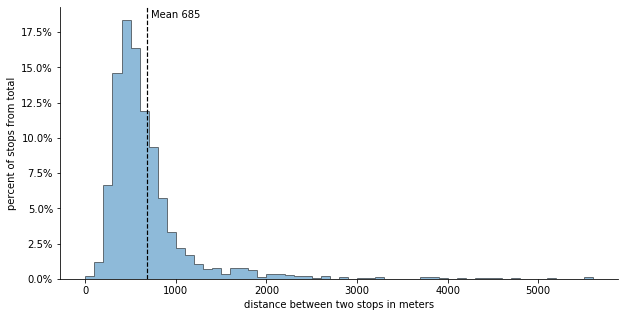

In [48]:
fig,ax = plt.subplots(figsize = (10, 5))

x = df_gmaps_data['distance_m']

plt.hist(x, weights=np.ones(len(x)) / len(x), histtype='stepfilled',
             bins=np.arange(0, 5601, 100), alpha=.5, ec="k")

plt.axvline(x.mean(), color='#000000', linestyle='dashed', linewidth=1.2)

plt.xlabel('distance between two stops in meters')
plt.ylabel('percent of stops from total')
ax.text(x=x.mean()+40, y=.185, s='Mean '+str(int(x.mean())))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# plt.savefig('stop_distance_overall.png', bbox_inches='tight', dpi=500)

plt.show()

Since we already found out that the minimum distance between two stops is 47m then the stops near my home are not with the shortest distance. But is it still one of the shortest? Let's find their coordinates first.

In [25]:
df_stops.loc[(df_stops['Name']=='Varre')|(df_stops['Name']=='Õilme')]

,ID,SiriID,Lat,Lng,Name,Coordinates
2160,07506-1,72,5941919,2475413,Varre,"59.41919, 24.75413"
2186,12909-1,4274,5941906,2475412,Varre,"59.41906, 24.75412"
2405,13201-1,1355,5941964,2475139,Varre,"59.41964, 24.75139"
2409,13202-1,1356,5942117,2475080,Õilme,"59.42117, 24.7508"


Since there are three Varre stops, I had to check manually which one is the correct one.

In [26]:
x = df_gmaps_data.loc[df_gmaps_data['coordinates']==("59.41964, 24.75139", 
                                                     "59.42117, 24.7508"), 
                                    'distance_m'].values[0]
print(x) # distance between Varre and Õilme

174


In [27]:
round(len(df_gmaps_data.loc[df_gmaps_data['distance_m']<=x]) / 
      len(df_gmaps_data) * 100, 2)

0.92

It turns out the distance between the stops near my home is in the top 1% of the shortest in Tallinn.

# Analysing total route distances

Now let's see how the data for the whole route distances look like.

To calculate the distance of the whole route I start from adding the coordinate pairs of the adjacent stops to the routes table so that I could use those pairs to get the distance.

In [28]:
route_stops_coordinate_pairs = []

for i, coordinates in enumerate(df_routes['StopsCoordinates']):
    pairs = []
    for j in range(len(coordinates)-1):
        pairs.append((coordinates[j], coordinates[j+1]))
    route_stops_coordinate_pairs.append(pairs)

df_routes['StopsCoordPairs'] = route_stops_coordinate_pairs

df_routes[['RouteNum', 'StopsCoordPairs']].head()

,RouteNum,StopsCoordPairs
0,1A,"[(59.43647, 24.75669, 59.43712, 24.76218), (59..."
1,1A,"[(59.43711, 24.75862, 59.43712, 24.76218), (59..."
2,1A,"[(59.50906, 24.83017, 59.50404, 24.82818), (59..."
3,2,"[(59.40628, 24.81604, 59.40802, 24.81109), (59..."
4,2,"[(59.44461, 24.76014, 59.4427, 24.76475), (59...."


Now that I added the coordinate pairs, I'll substitute them with the distance data and sum them up to have the total length of the route.

In [29]:
dist_dict = dict(zip(df_gmaps_data.coordinates, df_gmaps_data.distance_m))

df_routes['StopsDistances'] = df_routes['StopsCoordPairs'].apply(lambda x: [dist_dict.get(item,item) for item in x])

df_routes['TotalDistance_km'] = df_routes['StopsDistances'].apply(lambda x: sum(x)) / 1000

df_routes[['RouteNum', 'StopsDistances', 'TotalDistance_km']].head()

,RouteNum,StopsDistances,TotalDistance_km
0,1A,"[858, 876, 596, 280, 992, 603, 546, 600, 320, ...",12.548
1,1A,"[201, 876, 596, 280, 992, 603, 546, 600, 320, ...",11.891
2,1A,"[1092, 856, 581, 415, 589, 532, 1456, 567, 465...",14.633
3,2,"[408, 331, 1053, 411, 830, 483, 614, 502, 449,...",8.785
4,2,"[1853, 627, 519, 1864, 506, 392, 736, 521, 802...",10.477


Let's see some descriptive info on the route distances.

In [30]:
df_routes[['TotalDistance_km']].describe().round(1)

,TotalDistance_km
count,201.0
mean,11.6
std,4.8
min,0.4
25%,8.5
50%,11.1
75%,14.5
max,26.5


And now, let's also visualize the distribution of the route distances.

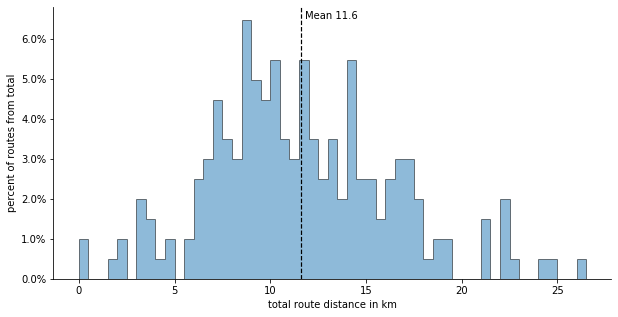

In [55]:
fig,ax = plt.subplots(figsize = (10, 5))
x = df_routes['TotalDistance_km']

plt.hist(x, weights=np.ones(len(x)) / len(x), histtype='stepfilled',
             bins=np.arange(0, 27, .5), alpha=.5, ec="k")
plt.axvline(x.mean(), color='#000000', linestyle='dashed', linewidth=1.2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('total route distance in km')
plt.ylabel('percent of routes from total')
ax.text(x=x.mean()+.2, y=.065, s='Mean '+str(round(x.mean(),1)))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# plt.savefig('route_distance_overall.png', bbox_inches='tight', dpi=500)

plt.show()

# Analysing distances between stops by transport type

I'm also curious how the distributions look by transport type. I do have the transport type in the routes data frame but since some of the stops are shared between different transport types, I need to make a new data frame.

I start by extracting the coordinate pairs for each transport type from the existing routes data frame.

In [32]:
transport = []
coordinates = []
for i, coordpair in enumerate(df_routes['StopsCoordPairs']):
    for coord in coordpair:
        transport.append(df_routes.loc[i, 'TransportType'])
        coordinates.append(coord)

In [33]:
df_stops_by_transport = pd.DataFrame({'TransportType':transport, 'StopCoordinates':coordinates} )

I then need to merge it with the data frame of distances collected with Google Maps.

In [34]:
df_stops_by_transport = df_stops_by_transport.merge(df_gmaps_data, how='left', 
                                                    left_on='StopCoordinates', right_on='coordinates')
df_stops_by_transport = df_stops_by_transport[['TransportType', 'StopCoordinates', 'distance_m']]
print(len(df_stops_by_transport))
df_stops_by_transport.head()

3706


,TransportType,StopCoordinates,distance_m
0,bus,"(59.43647, 24.75669, 59.43712, 24.76218)",858
1,bus,"(59.43712, 24.76218, 59.4391, 24.77716)",876
2,bus,"(59.4391, 24.77716, 59.44098, 24.78701)",596
3,bus,"(59.44098, 24.78701, 59.44232, 24.79074)",280
4,bus,"(59.44232, 24.79074, 59.44816, 24.8033)",992


Since some routes which are of the same transport type share some of the stops as well, I have many duplicates in the data. So let's remove them.

In [35]:
df_stops_by_transport.drop_duplicates(inplace=True)
print(len(df_stops_by_transport))

1469


Let's visualize!

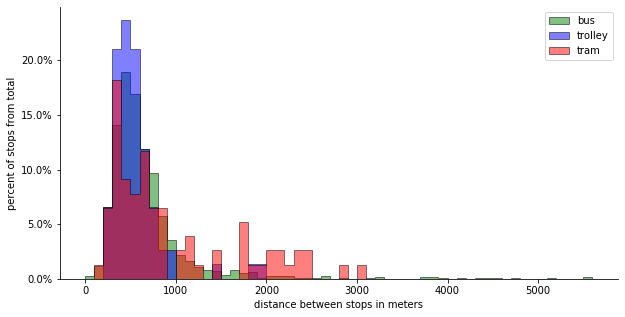

In [36]:
fig,ax = plt.subplots(figsize = (10, 5))

bus_data = df_stops_by_transport.loc[df_stops_by_transport['TransportType']=='bus', 'distance_m']
trolley_data = df_stops_by_transport.loc[df_stops_by_transport['TransportType']=='trolley', 'distance_m']
tram_data = df_stops_by_transport.loc[df_stops_by_transport['TransportType']=='tram', 'distance_m']
colors = ['green', 'blue', 'red']

for i, data in enumerate([bus_data, trolley_data, tram_data]):
    plt.hist(data, weights=np.ones(len(data)) / len(data),
             histtype='stepfilled',
             bins=np.arange(0, 5601, 100), 
             color=colors[i],
             alpha=.5, ec="k")

plt.xlabel('distance between stops in meters')
plt.ylabel('percent of stops from total')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(labels=['bus', 'trolley', 'tram'])

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# plt.savefig('stop_distance_by_type.png', bbox_inches='tight', dpi=500)

plt.show()

It looks too messy so let's use the small multiples approach.

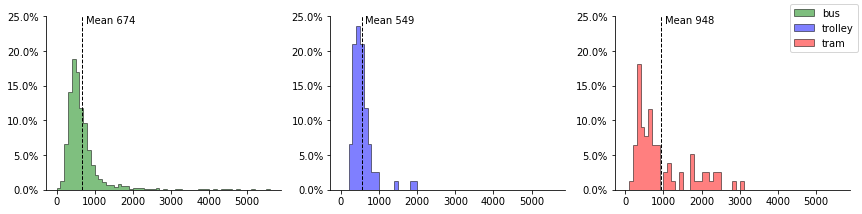

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (12, 3))

bus_data = df_stops_by_transport.loc[df_stops_by_transport['TransportType']=='bus', 'distance_m']
trolley_data = df_stops_by_transport.loc[df_stops_by_transport['TransportType']=='trolley', 'distance_m']
tram_data = df_stops_by_transport.loc[df_stops_by_transport['TransportType']=='tram', 'distance_m']
colors = ['green', 'blue', 'red']

for i, data in enumerate([bus_data, trolley_data, tram_data]):
    ax[i].hist(data, histtype='stepfilled',
               weights=np.ones(len(data)) / len(data),
               bins=np.arange(0, 5601, 100),
               alpha=.5,
               color=colors[i], ec="k", zorder=1)
    ax[i].axvline(data.mean(), color='#000000', linestyle='dashed', linewidth=1, label='_nolegend_')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].yaxis.set_major_formatter(PercentFormatter(1))
    ax[i].set_ylim(0, .25)
    ax[i].text(x=data.mean()+90, y=.24, s='Mean '+str(int(round(data.mean(),0))))

plt.figlegend(labels=['bus', 'trolley', 'tram', 'bus', 'trolley', 'tram'])

fig.tight_layout()

# plt.savefig('stop_distance_by_type_multiple.png', bbox_inches='tight', dpi=500)

plt.show()

In [38]:
df_stops_by_transport.pivot_table(values='distance_m',
                                  index='TransportType',
                                  aggfunc=('count', 'median', 'mean', 'std', 'min', 'max')).round()

,count,max,mean,median,min,std
TransportType,,,,,,
bus,1316.0,5575.0,674.0,542.0,47.0,534.0
tram,77.0,3069.0,948.0,641.0,179.0,732.0
trolley,76.0,1954.0,549.0,479.0,209.0,293.0


# Analysing total route distances by transport type

And now I want to see the data by transport type for the whole routes as well. Fortunately this time, I already have the data in the necessary form in the routes data frame so no need to do anything extra.

In [39]:
df_routes[['TransportType', 'TotalDistance_km']].head()

,TransportType,TotalDistance_km
0,bus,12.548
1,bus,11.891
2,bus,14.633
3,bus,8.785
4,bus,10.477


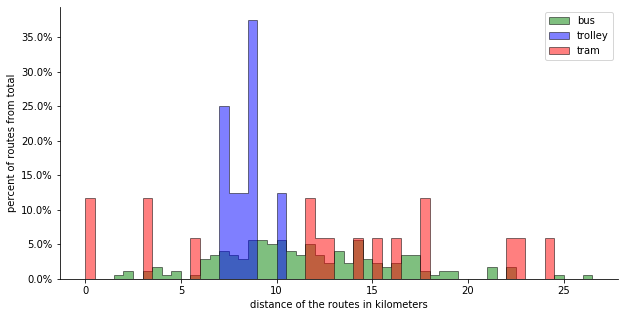

In [40]:
fig,ax = plt.subplots(figsize = (10, 5))

bus_data = df_routes.loc[df_routes['TransportType']=='bus', 'TotalDistance_km']
trolley_data = df_routes.loc[df_routes['TransportType']=='trolley', 'TotalDistance_km']
tram_data = df_routes.loc[df_routes['TransportType']=='tram', 'TotalDistance_km']
colors = ['green', 'blue', 'red']

for i, data in enumerate([bus_data, trolley_data, tram_data]):
    plt.hist(data, weights=np.ones(len(data)) / len(data),
             histtype='stepfilled',
             color=colors[i],
             bins=np.arange(0, 27, .5),
             alpha=.5, ec="k")

plt.xlabel('distance of the routes in kilometers')
plt.ylabel('percent of routes from total')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(labels=['bus', 'trolley', 'tram'])

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# plt.savefig('route_distance_by_type.png', bbox_inches='tight', dpi=500)

plt.show()

In [41]:
df_routes.pivot_table(values='TotalDistance_km',
                      index='TransportType',
                      aggfunc=('count', 'median', 'mean', 'std', 'min', 'max')).round(1)

,count,max,mean,median,min,std
TransportType,,,,,,
bus,176,26.5,11.7,11.2,1.5,4.6
tram,17,24.5,12.5,12.9,0.4,7.6
trolley,8,10.3,8.4,8.5,7.3,0.9
